#**1**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import zipfile

zip_file = zipfile.ZipFile('/content/drive/MyDrive/symbols.zip', 'r')
zip_file.extractall('data')
zip_file.close()

#**1.1**

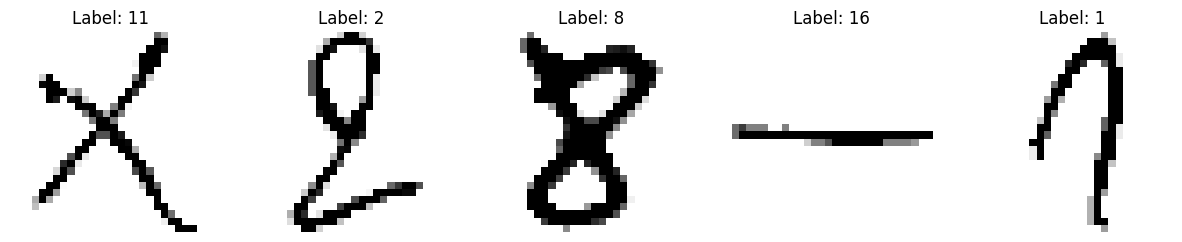

In [3]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

data_path = '/content/data/symbols'
label_mapping = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7,
                 '8': 8, '9': 9, 'w': 10, 'x': 11, 'y': 12, 'z': 13, 'dot': 14,
                 'plus': 15, 'minus': 16, 'slash': 17}

class CustomDataset(Dataset):
    def __init__(self, img_dir, img_labels, transform=None):
        self.img_dir = img_dir
        self.img_labels = img_labels
        self.transform = transform

    def _get_label(self, file_name):
        label = file_name.split('-')[0]
        if label.isdigit():
            return int(label)
        else:
            return label_mapping.get(label, -1)

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path, label = self.img_labels[idx]
        image = Image.open(os.path.join(self.img_dir, img_path)).convert("L")
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([transforms.ToTensor()])

img_labels = [(file_name, CustomDataset._get_label(None, file_name)) for file_name in os.listdir(data_path)]

dataset = CustomDataset(img_dir=data_path, img_labels=img_labels, transform=transform)

train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

def show_sample_images(data_loader, num_images=5):
    images, labels = next(iter(data_loader))
    images = images.numpy()
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i][0], cmap='gray')
        ax.set_title(f'Label: {labels[i].item()}')
        ax.axis('off')
    plt.show()

show_sample_images(train_loader, num_images=5)

#**1.2**

In [4]:
from sklearn.model_selection import train_test_split

train_data, val_test_data = train_test_split(dataset, test_size=0.4, random_state=10)
val_data, test_data = train_test_split(val_test_data, test_size=0.5, random_state=10)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


#**1.3**

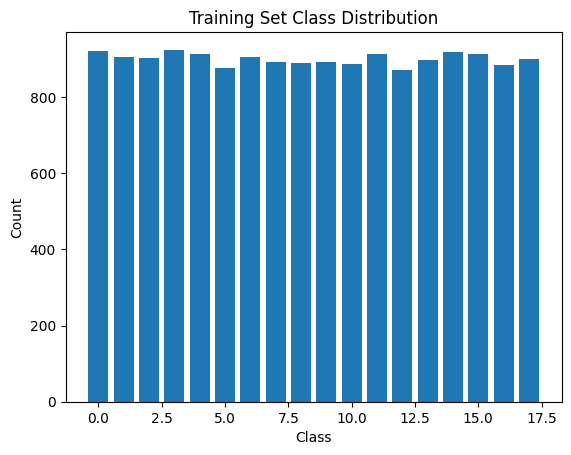

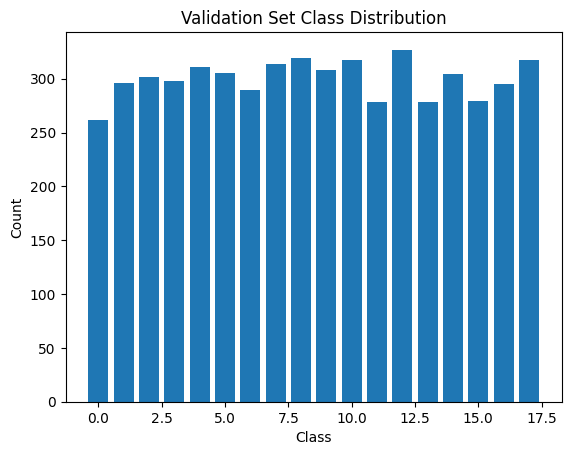

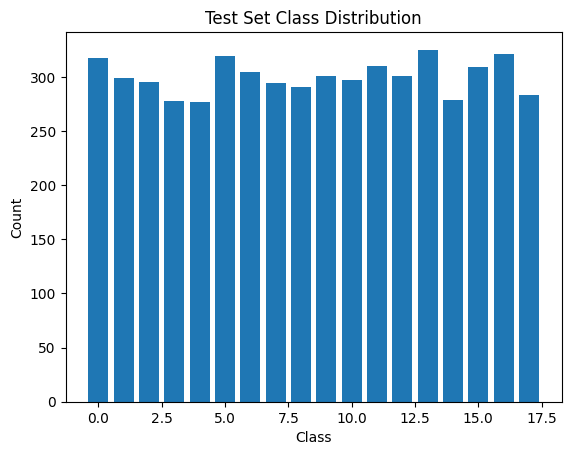

In [5]:
import numpy as np

def plot_class(data_loader, title):
    class_counts = np.zeros(18)
    for _, labels in data_loader:
        for label in labels:
            class_counts[label] += 1

    plt.figure()
    plt.bar(range(len(class_counts)), class_counts)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(title)
    plt.show()

plot_class(train_loader, 'Training Set Class Distribution')
plot_class(val_loader, 'Validation Set Class Distribution')
plot_class(test_loader, 'Test Set Class Distribution')


#**1.4**


The problem we might encounter is that the distribution of classes may not be equal in validation set and test set. so we will face some unwanted result and effects the accuracy of our algorithm.

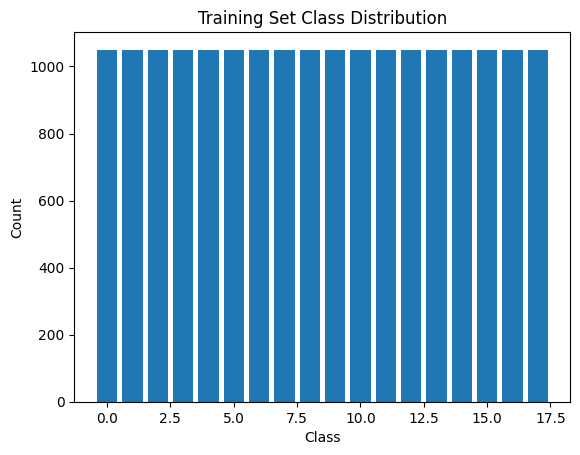

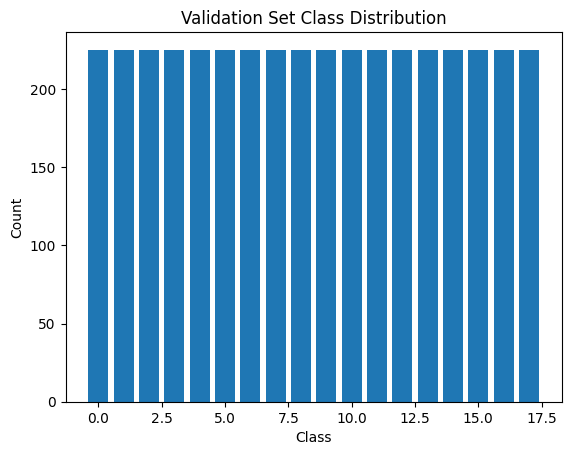

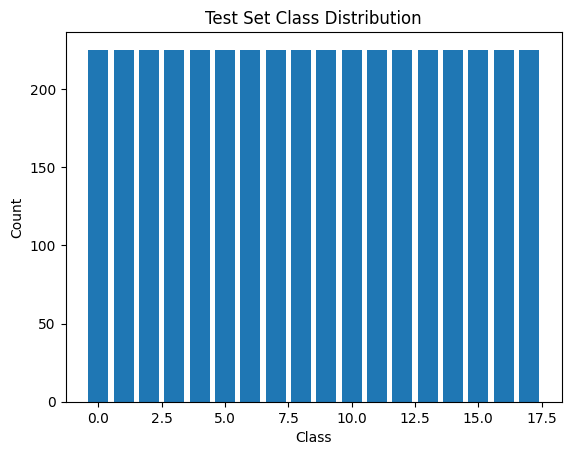

In [6]:
from sklearn.model_selection import train_test_split
# stratify helps to keep the balance between calss distribution


train_img_labels, val_test_img_labels = train_test_split(
    dataset.img_labels, test_size=0.3, random_state=42, stratify=[label for _, label in dataset.img_labels]
)

val_img_labels, test_img_labels = train_test_split(
    val_test_img_labels, test_size=0.5, random_state=42, stratify=[label for _, label in val_test_img_labels]
)

train_dataset = CustomDataset(img_dir=data_path, img_labels=train_img_labels, transform=transform)
val_dataset = CustomDataset(img_dir=data_path, img_labels=val_img_labels, transform=transform)
test_dataset = CustomDataset(img_dir=data_path, img_labels=test_img_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

plot_class(train_loader, 'Training Set Class Distribution')
plot_class(val_loader, 'Validation Set Class Distribution')
plot_class(test_loader, 'Test Set Class Distribution')

#**1.5**

####Why underfitting happens?
**Simplistic Model:** If the model is too simple, it may not be capable of capturing the complexities in the data, leading to high bias.

**Insufficient Training Data:** The size of the training dataset used might not be enough to allow the model to learn the patterns effectively.

**Inadequate Features:** The input features used to train the model might not be adequate representations of the underlying factors influencing the target variable.

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class UnderfittingModel(nn.Module):
    def __init__(self):
        super(UnderfittingModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(4 * 14 * 14, 18)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 4 * 14 * 14)
        x = self.fc1(x)
        return x


#**1.6**

###Why overfitting happens
**High Model Complexity:** Overfitting often occurs with models that have too many parameters relative to the number of observations. These models are highly flexible and can adapt too closely to the training data, capturing noise as if it were a significant pattern.

**Lack of Regularization:** Regularization techniques like L1 or L2 are designed to impose simplicity by penalizing the magnitude of the coefficients of features. Without regularization, a model might give undue importance to less significant features, leading to overfitting.

**Insufficient Training Data:** If the dataset is too small, the model may not be exposed to a representative sample of the broader data distribution. This lack of exposure can lead the model to learn patterns that don't generalize well to unseen data.

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class OverfittingModel(nn.Module):
    def __init__(self):
        super(OverfittingModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(512 * 1 * 1, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 18)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 512 * 1 * 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


#**1.7**

We will use cross_entropy loss function to determine the loss for multy class classification. because the output of this loss function is a probability of each calss so it is better for us to use this.

In [9]:
import torch.optim as optim

model = OverfittingModel()
optimizer = optim.Adam(model.parameters())
loss_fn = F.cross_entropy

#**1.8**

In [10]:
def train_one_epoch(model, data_loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    correct = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()

    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = correct / len(data_loader.dataset)
    return avg_loss, accuracy


#**1.9**

In [11]:
def train(model, train_loader, val_loader, optimizer, loss_fn, epochs, device):
    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
        val_loss, val_acc = evaluate(model, val_loader, loss_fn, device)

        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f}')
        print(f'Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.4f}')

def evaluate(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()

    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = correct / len(data_loader.dataset)
    return avg_loss, accuracy


#**1.10**

In [12]:
!pip install wandb

In [13]:
import wandb
wandb.login()

wandb: Currently logged in as: arashazhand (arash_azhand). Use `wandb login --relogin` to force relogin


True

In [14]:
import wandb

wandb.init(project="SymbolClassification")

learning_rates = [0.001, 0.01, 0.1]
epochs = 5
best_val_acc = 0
best_lr = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for lr in learning_rates:
    model = OverfittingModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = F.cross_entropy

    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
        val_loss, val_acc = evaluate(model, val_loader, loss_fn, device)

        wandb.log({
            "Learning Rate": lr,
            "Train Loss": train_loss,
            "Train Accuracy": train_acc,
            "Validation Loss": val_loss,
            "Validation Accuracy": val_acc,
            "Epoch": epoch+1
        })

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_lr = lr

        print(f'LR {lr}, Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

wandb.finish()

print(f"The best learning rate is: {best_lr}")



LR 0.001, Epoch 1/5, Train Loss: 0.0289, Train Acc: 0.6952, Val Loss: 0.0050, Val Acc: 0.9543
LR 0.001, Epoch 2/5, Train Loss: 0.0045, Train Acc: 0.9571, Val Loss: 0.0051, Val Acc: 0.9521
LR 0.001, Epoch 3/5, Train Loss: 0.0028, Train Acc: 0.9714, Val Loss: 0.0032, Val Acc: 0.9696
LR 0.001, Epoch 4/5, Train Loss: 0.0023, Train Acc: 0.9770, Val Loss: 0.0028, Val Acc: 0.9726
LR 0.001, Epoch 5/5, Train Loss: 0.0019, Train Acc: 0.9808, Val Loss: 0.0024, Val Acc: 0.9753
LR 0.01, Epoch 1/5, Train Loss: 0.0963, Train Acc: 0.0536, Val Loss: 0.0907, Val Acc: 0.0556
LR 0.01, Epoch 2/5, Train Loss: 0.0905, Train Acc: 0.0534, Val Loss: 0.0907, Val Acc: 0.0556
LR 0.01, Epoch 3/5, Train Loss: 0.0905, Train Acc: 0.0504, Val Loss: 0.0907, Val Acc: 0.0556
LR 0.01, Epoch 4/5, Train Loss: 0.0904, Train Acc: 0.0542, Val Loss: 0.0907, Val Acc: 0.0556
LR 0.01, Epoch 5/5, Train Loss: 0.0904, Train Acc: 0.0551, Val Loss: 0.0907, Val Acc: 0.0556
LR 0.1, Epoch 1/5, Train Loss: 4794.9647, Train Acc: 0.0550, Val 

Epoch,▁▃▅▆█▁▃▅▆█▁▃▅▆█
Learning Rate,▁▁▁▁▁▂▂▂▂▂█████
Train Accuracy,▆████▁▁▁▁▁▁▁▁▁▁
Train Loss,▁▁▁▁▁▁▁▁▁▁█▁▁▁▁
Validation Accuracy,█████▁▁▁▁▁▁▁▁▁▁
Validation Loss,▁▁▁▁▁██████████
Epoch,5
Learning Rate,0.1
Train Accuracy,0.05159
Train Loss,0.09095
Validation Accuracy,0.05556


The best learning rate is: 0.001


#**1.11**

In [15]:
best_learning_rate = best_lr
epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = OverfittingModel().to(device)

optimizer = optim.Adam(model.parameters(), lr=best_learning_rate)
loss_fn = F.cross_entropy

train(model, train_loader, val_loader, optimizer, loss_fn, epochs, device)

test_loss, test_accuracy = evaluate(model, test_loader, loss_fn, device)

print(f'\nTest loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}')


Epoch 1/10
Train loss: 0.0242, Train accuracy: 0.7437
Validation loss: 0.0043, Validation accuracy: 0.9558
Epoch 2/10
Train loss: 0.0037, Train accuracy: 0.9648
Validation loss: 0.0028, Validation accuracy: 0.9704
Epoch 3/10
Train loss: 0.0026, Train accuracy: 0.9753
Validation loss: 0.0029, Validation accuracy: 0.9746
Epoch 4/10
Train loss: 0.0019, Train accuracy: 0.9828
Validation loss: 0.0027, Validation accuracy: 0.9743
Epoch 5/10
Train loss: 0.0016, Train accuracy: 0.9846
Validation loss: 0.0034, Validation accuracy: 0.9756
Epoch 6/10
Train loss: 0.0014, Train accuracy: 0.9864
Validation loss: 0.0028, Validation accuracy: 0.9738
Epoch 7/10
Train loss: 0.0014, Train accuracy: 0.9872
Validation loss: 0.0030, Validation accuracy: 0.9746
Epoch 8/10
Train loss: 0.0014, Train accuracy: 0.9880
Validation loss: 0.0029, Validation accuracy: 0.9748
Epoch 9/10
Train loss: 0.0009, Train accuracy: 0.9919
Validation loss: 0.0023, Validation accuracy: 0.9788
Epoch 10/10
Train loss: 0.0008, Train